In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from Modules import map_to_embeddings
from Modules import drawborder
from Modules import generate_figures
from Modules import read_data
from Modules import heat_pca

## Define Functions

In [2]:
def manage_ratio_axes(ax):
    ax.axis([0,100,0,100])
    ticks = [0, 25, 50, 75, 100]
    ax.set_xticks(ticks), ax.set_yticks(ticks)
    ax.set_xticklabels(ticks, family='Arial')
    ax.set_yticklabels(ticks, family='Arial')
    ax.set_xlabel('Expression rates (%)\ncurrent study', fontsize=8)
    ax.set_ylabel("Expression rate (%)\nGSE99888 (CA1-IN study)", fontsize=8)
    ax.tick_params(size=1, labelsize=6, pad=1, width=.5)
    
    return

def plot_kde_plot(df, ax):
    low, high, step = 0, 100, 1
    
    XX, YY = np.mgrid[low:(high+step):step, low:(high+step):step]
    xy_sample = np.vstack([XX.ravel(), YY.ravel()]).T
    #bandwidth = np.sqrt(np.square(step) + np.square(step))
    bandwidth = 1
    
    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(df.values)
    
    ZZ = np.power(np.exp(kde_skl.score_samples(xy_sample)),.5)
    ZZ = np.reshape(ZZ, XX.shape)
    ZZ[ZZ>(ZZ.max()/4)] = ZZ.max()/4
    
    levels = np.linspace(ZZ.min(), ZZ.max(), 201)[5:]
    ax.contourf(XX, YY, ZZ, levels=levels, cmap=mpl.cm.Reds, zorder=0)
    
    plotlist = df.values + .001*np.random.rand(*df.shape)
    params = {'frac':.025, 'delta':1, 'is_sorted':False, 'return_sorted':True}
    plotlist = lowess(plotlist[:,1], plotlist[:,0], **params)
    
    ax.plot(plotlist[:,0], plotlist[:,1], linewidth=1, color='black', zorder=2)
    
    return

def plot_key_genes(df, gene_sets, ax):
    genes = {gene for gene_set in gene_sets for gene in heat_pca.get_differential_count(gene_set, count=100)}
    genes = sorted(genes)
    df = df.loc[genes,:]
    
    ax.scatter(df['This Study'], df['CA1-INs'], s=1, color='#000000', zorder=1)
    
    plotlist = df.values + .001*np.random.rand(*df.shape)
    params = {'frac':.2, 'delta':10, 'is_sorted':False, 'return_sorted':True}
    plotlist = lowess(plotlist[:,1], plotlist[:,0], **params)
    
    ax.plot(plotlist[:,0], plotlist[:,1], linewidth=1, color='purple', zorder=2)
    
    return

# Create Row 1

In [3]:
def plot_morphological_data(fig):
    targets = ['Morph-PV-types', 'MorphMarker-PV-types', 'MorphDirectional-PV-types']
    orders = [['vAAC', 'hBIC', 'vBIC', 'vBC', 'hBC'],
              ['AAC', 'BC', 'BIC'],
              ['Vertical', 'Horizontal']
             ]
    titles = ['Five morphological types', 'Three morphological types', 'Dendritic direction-based types']
    column_labels = orders
    label_by = ['proMMT-PV-types', 'proMMT-PV-types', 'proMMT-PV-types']
    width = .154
    lefts = [0.176, 0.416, 0.656]
    axranges = [[left, .535, width, .33] for left in lefts]
    label_genes = [True, True, True]
    legend_args = ({'loc':'upper center', 'bbox_to_anchor':(.50, -0.15), 'ncol':3},
              {'loc':'upper center', 'bbox_to_anchor':(.50, -0.15), 'ncol':3},
              {'loc':'upper center', 'bbox_to_anchor':(.50, -0.15), 'ncol':3}
             )
    heat_args = ({'tick_size':5}, {'tick_size':5}, {'tick_size':5})
    
    df_tpm, df_labels = read_data.read_tpm_data('Lab_Pvalb', log=True, age_cutoff = 20, translabels=True)
    df_labels['Age-PV-types'] = '21-30'
    df_labels.loc[np.logical_and(df_labels.Age>30, df_labels.Age<=40), 'Age-PV-types'] = '31-40'
    df_labels.loc[df_labels.Age>40, 'Age-PV-types'] = '>40'
    edger_genes = heat_pca.get_edger_genes(['Morph', 'MorphMarker', 'MorphDirectional'])
    
    group = zip(axranges, targets, orders, label_by, column_labels, label_genes, legend_args, heat_args, titles)
    for col, (axrange, target, order, label_order, column_label, label_gene, legend_arg, heat_arg, title)\
        in enumerate(group):
        args = (fig, df_tpm, df_labels, title, target, order, column_label, label_order, axrange, label_gene)
        heat_arg['red_genes'] = edger_genes
        kwargs = {'legend_args':legend_arg,
                  'heat_args':heat_arg,
                  'add_legend':(col==1),
                  'differential_args':{'method':'Count'}}
        heat_pca.do_heat_pca(*args, **kwargs)
    
    return

# Create Row 2

In [4]:
def plot_morphology_pca(ax):
    df_tpm, df_labels = read_data.read_tpm_data('Lab_Pvalb', log=True, age_cutoff = 20, translabels=True)
    df_color = map_to_embeddings.get_color_dataframe()
    
    genes = sorted(set(heat_pca.get_differential_genes('Morph', method='Count')
                        + heat_pca.get_differential_genes('MorphMarker', method='Count')
                        + heat_pca.get_differential_genes('MorphDirectional', method='Count')
                       ))
    labels = df_labels['Morph-PV-types']
    labels = labels[~labels.isna()]
    df_tpm = df_tpm.loc[genes,labels.index]
    df_tpm.columns = labels.values
    
    legend_args = {'loc':'upper center', 'bbox_to_anchor':(.50,-0.15), 'ncol':3}
    heat_pca.do_pca_plot(ax, df_tpm, df_color,
                         scatter_args={'s':16},
                         legend_args=legend_args)
    ax.set_title('Morphology-based\ngene selection', fontsize=7, y=.98)
    
    return

def plot_mapping_genes(ax):
    params = {'sep':'\t', 'header':0, 'index_col':0}
    df_rate = pd.read_csv('Mapping/DifferentialMapping/Lin_Harris_rates.tsv', **params)
    df_rate = df_rate.loc[df_rate.max(axis=1)>0,:]
    
    gene_sets = ['Morph', 'MorphMarker', 'MorphDirectional']
    plot_kde_plot(df_rate, ax)
    plot_key_genes(df_rate, gene_sets, ax)
    manage_ratio_axes(ax)
    
    return

def get_line(clf, x_low, y_low, x_high, y_high):
    intercept = -clf.intercept_ / clf.coef_[0][1]
    coef = -clf.coef_[0][0] / clf.coef_[0][1]
    
    # y = intercept + coef*x
    x_line = x_line = np.linspace(x_low, x_high, 2)
    y_line = intercept + coef*x_line
    
    if y_line[0] < y_low and y_line[-1] > y_high:
        y_line = np.linspace(y_low, y_high)
        x_line = (y_line - intercept) / coef
    
    return x_line, y_line

def outlier_clusters(df, ax, n_clusters=3):
    points = df.loc[:,['X', 'Y']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    labels = kmeans.labels_
    
    colors = ['green', 'purple', 'black']
    
    for label, color in zip(np.unique(labels), colors):
        inds = labels == label
        label_points = points[inds,:]
        outline = drawborder.ShiftedGrahamScan(label_points)
        ax.plot(outline[:,0], outline[:,1], linewidth=1, color=color)
    
    return

def plot_differential_mapping(ax):
    params = {'sep':'\t', 'header':0, 'index_col':[0,1]}
    df_embed = pd.read_csv('Mapping/DifferentialMapping/Harris_Multi.tsv', **params)
    df_map = pd.read_csv('Mapping/DifferentialMapping/Lab_Pvalb_Multi.tsv', **params)
    df_color = map_to_embeddings.get_color_dataframe()
    
    ax.set_xticks([]), ax.set_yticks([])
    
    labels = []
    for celltype in set(df_embed.index.get_level_values('CellType')):
        edge, face, marker = df_color.loc[celltype,:]
        inds = df_embed.index.get_level_values('CellType') == celltype
        
        kwargs = {'facecolor':face,
                  'edgecolor':edge,
                  'marker':marker,
                  'zorder':0,
                  's':8,
                  'linewidth':.5,
                  'label':None
                 }
        ax.scatter(df_embed.loc[inds, 'X'], df_embed.loc[inds, 'Y'], **kwargs)
        labels.append(celltype)
    
    points = ax.get_children()
    kwargs = {'fontsize':5,
              'ncol':3,
              'loc':'upper right',
              'bbox_to_anchor':(1,-.3),
              'columnspacing':.5,
              'handletextpad':.25
             }
    
    clf = SVC(kernel='linear', C=1000)
    X = df_embed.values
    Y = (df_embed.index.get_level_values('CellType').str.startswith('Pvalb.C1ql1')).astype(int)
    clf.fit(X, Y)
    x_low, y_low = X.min(axis=0)
    x_high, y_high = X.max(axis=0)
    x_step, y_step = .02 * (x_high-x_low), .02*(y_high-y_low)
    x_low, y_low = x_low - x_step, y_low - y_step
    x_high, y_high = x_high + x_step, y_high + y_step
    x_line = np.linspace(x_low, x_high, 4)
    
    x_line, y_line = get_line(clf, x_low, y_low, x_high, y_high)
    ax.plot(x_line, y_line, linewidth=0.5, color='black', linestyle='dashed')
    ax.axis([x_low, x_high, y_low, y_high])
    
    for celltype in ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC']:
        edge, face, marker = df_color.loc[celltype,:]
        inds = df_map.index.get_level_values('CellType') == celltype
        kwargs = {'facecolor':face,
                  'edgecolor':edge,
                  'marker':marker,
                  'zorder':1,
                  's':16,
                  'label':celltype,
                  'linewidth':.5
                 }
        ax.scatter(df_map.loc[inds, 'X'], df_map.loc[inds, 'Y'], **kwargs)
    kwargs = {'fontsize':5,
              'ncol':1,
              'handletextpad':0.2,
              'loc':'lower right',
              'bbox_to_anchor':(.99, .01),
              'borderpad':0,
              'borderaxespad':0
             }
    legend = ax.legend(**kwargs)
    legend.get_frame().set_linewidth(.5)
    
    outlier_clusters(df_map, ax, n_clusters=2)
    
    kwargs = {'style':'italic', 'fontsize':7, 'ha':'center', 'va':'bottom', 'transform':ax.transAxes}
    ax.text(.25, 1.05, 'Pvalb.C1ql1', **kwargs)
    ax.text(.75, 1.05, 'Pvalb.Tac1', **kwargs)
    ax.set_xlabel(r'UMAP$_1$', fontsize=7)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7)
    
    return

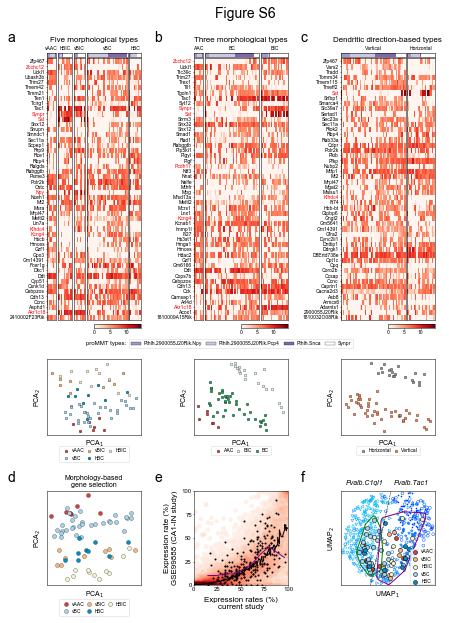

In [5]:
fig, axes = generate_figures.generate_figure_S06()

plot_morphological_data(fig)
plot_morphology_pca(axes['D'])
plot_mapping_genes(axes['E'])
plot_differential_mapping(axes['F'])
fig.savefig('Figures/Figure S6.pdf')
plt.show()